In [1]:
import os
import datetime as dt
import time
import json

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics

import lightgbm as lgb
from lightgbm import LGBMClassifier

from feature_selector import *

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.options.display.max_columns = 80
pd.options.display.float_format = lambda x : "{:,.2f}".format(x)


In [3]:
train = pd.read_csv('clean_data/train.csv', dtype={'Id':str})
test = pd.read_csv('clean_data/test.csv', dtype={'Id':str})

train.shape, test.shape

((15120, 54), (565892, 55))

In [4]:
with open('clean_data/train_cols.json', 'r') as f:
    train_cols = json.load(f)

In [5]:
train_cols.keys()
id_cols = train_cols['id']
cat_cols = train_cols['cat_cols']
int_cols = train_cols['int_cols']
target_col = train_cols['target_col']

ftr_cols = int_cols + cat_cols

In [6]:
ytrain = train[target_col]

## Agenda

    - Scale Data
    - KMeans and DBSCAN for Cluster Labels as features
    - Clustering On PCA/SVD/NMF
    - NaiveBayes Probabilities as Features
    - Run Through Feature Selector
    - Polynomial Features
    - Feature Selector Again

### Scale Data

In [ ]:
mm = MinMaxScaler()
xtrain_scaled = mm.fit_transform(train[ftr_cols])
xtest_scaled = mm.transform(test[ftr_cols])
ytrain = train[target_col]

In [ ]:
pd.DataFrame(xtrain_scaled, columns = ftr_cols).to_csv('clean_data/xtrain_scaled.csv',index=False)
pd.DataFrame(xtest_scaled, columns=ftr_cols).to_csv('clean_data/xtest_scaled.csv',index=False)

### KMeans

In [ ]:
km_train_data = {}
km_test_data = {}
for k in range(3,15):
    print(k)
    km = KMeans(k)
    km_train = km.fit_predict(xtrain_scaled)
    km_test = km.predict(xtest_scaled)
    
    km_train_data['K'+str(k)] = km_train
    km_test_data['K'+str(k)] = km_test
    
    
# make DFS
km_train_df = pd.DataFrame(km_train_data)
km_test_df = pd.DataFrame(km_test_data)

In [ ]:
km_train_df.to_csv('clean_data/km_train_df.csv',index=False)
km_test_df.to_csv('clean_data/km_test_df.csv',index=False)

### DBSCAN

DB has no transform method so we can't use it on new data

TODO: write predict method for db that just takes distances from cluster centers/avgs

In [ ]:
# db_train_data = {}
# db_test_data = {}
# for eps in [0.1, 0.5, 1, 1.25]:
#     for ms in range(5,50,10):
#         print('EPS:',eps, 'MS:', ms )
#         db = DBSCAN(eps,ms, n_jobs=-1)
#         db_train = db.fit_predict(xtrain_scaled)
#         db_test = db.predict(xtest_scaled)
#         db_train_data['EPS'+str(eps)+'_MS'+str(ms)] = db_train
#         db_test_data['EPS'+str(eps)+'_MS'+str(ms)] = db_test
        
# # make DFS
# db_train_df = pd.DataFrame(db_train_data)
# db_test_df = pd.DataFrame(db_test_df)

In [ ]:
# db_train_df.to_csv('clean_data/db_train_df.csv',index=False)
# db_test_df.to_csv('clean_data/db_test_df.csv',index=False)

### SVD  & PCA

In [ ]:
svd = TruncatedSVD(n_components = 10)

svd_train = svd.fit_transform(xtrain_scaled)
svd_test = svd.transform(xtest_scaled)

pca = PCA(n_components = 10)

pca_train = pca.fit_transform(xtrain_scaled)
pca_test = pca.transform(xtest_scaled)


# make dataframes
svd_train_df = pd.DataFrame(svd_train, columns = ['svd'+str(i) for i in range(svd_train.shape[1])])
svd_test_df = pd.DataFrame(svd_test, columns = ['svd'+str(i) for i in range(svd_train.shape[1])])

pca_train_df = pd.DataFrame(pca_train, columns = ['pca'+str(i) for i in range(svd_train.shape[1])])
pca_test_df = pd.DataFrame(pca_test, columns = ['pca'+str(i) for i in range(svd_train.shape[1])])

In [ ]:
svd_train_df.to_csv('clean_data/svd_train_df.csv',index=False)
svd_test_df.to_csv('clean_data/svd_test_df.csv',index=False)
pca_train_df.to_csv('clean_data/pca_train_df.csv',index=False)
pca_test_df.to_csv('clean_data/pca_test_df.csv',index=False)

### Cluster On Transformed Matrices

In [ ]:
km_svd_train_data = {}
km_svd_test_data = {}
for k in range(3,15):
    print(k)
    km = KMeans(k)
    km_train = km.fit_predict(svd_train)
    km_test = km.predict(svd_test)
    
    km_svd_train_data['SVD_K'+str(k)] = km_train
    km_svd_test_data['SVD_K'+str(k)] = km_test
    
km_pca_train_data = {}
km_pca_test_data = {}
for k in range(3,15):
    print(k)
    km = KMeans(k)
    km_train = km.fit_predict(pca_train)
    km_test = km.predict(pca_test)
    
    km_pca_train_data['PCA_K'+str(k)] = km_train
    km_pca_test_data['PCA_K'+str(k)] = km_test
    

# Make DFS
km_svd_train_df = pd.DataFrame(km_svd_train_data)
km_svd_test_df = pd.DataFrame(km_svd_test_data)

km_pca_train_df = pd.DataFrame(km_pca_train_data)
km_pca_test_df = pd.DataFrame(km_pca_test_data)



In [ ]:
km_svd_train_df.to_csv('clean_data/km_svd_train_df.csv',index=False)
km_svd_test_df.to_csv('clean_data/km_svd_test_df.csv',index=False)
km_pca_train_df.to_csv('clean_data/km_pca_train_df.csv',index=False)
km_pca_test_df.to_csv('clean_data/km_pca_test_df.csv',index=False)

In [ ]:
# db_svd_train_data = {}
# db_svd_test_data = {}
# for eps in [0.1, 0.5, 1, 1.25]:
#     for ms in range(5,50,10):
#         print('EPS:',eps, 'MS:', ms )
#         db = DBSCAN(eps,ms, n_jobs=-1)
#         db_train = db.fit_predict(svd_train)
#         db_test = db.predict(svd_test)
        
#         db_svd_train_data['SVD_EPS'+str(eps)+'_MS'+str(ms)] = db_train
#         db_svd_test_data['SVD_EPS'+str(eps)+'_MS'+str(ms)] = db_test
        
# db_pca_train_data = {}
# db_pca_test_data = {}
# for eps in [0.1, 0.5, 1, 1.25]:
#     for ms in range(5,50,10):
#         print('EPS:',eps, 'MS:', ms )
#         db = DBSCAN(eps,ms, n_jobs=-1)
#         db_train = db.fit_predict(pca_train)
#         db_test = db.predict(pca_test)
        
#         db_pca_train_data['PCA_EPS'+str(eps)+'_MS'+str(ms)] = db_train
#         db_pca_test_data['PCA_EPS'+str(eps)+'_MS'+str(ms)] = db_test
        

# # Make DFS
# db_svd_train_df = pd.DataFrame(db_svd_train_data)
# db_svd_test_df = pd.DataFrame(db_svd_test_data)

# db_pca_train_df = pd.DataFrame(db_pca_train_data)
# db_pca_test_df = pd.DataFrame(db_pca_test_data)


In [ ]:
# db_svd_train_df.to_csv('clean_data/db_svd_train_df.csv',index=False)
# db_svd_test_df.to_csv('clean_data/db_svd_test_df.csv',index=False)
# db_pca_train_df.to_csv('clean_data/db_pca_train_df.csv',index=False)
# db_pca_test_df.to_csv('clean_data/db_pca_test_df.csv',index=False)

### Naive Bayes

In [ ]:
class NaiveBayesClf():
    """
    Uses Bernoulli NB for Binary Features,
    Multinomial NB for integer ftrs,
    Gaussian NB for all other ftrs.
    
    Final Probs is average of 3 predicted probabilities of above models.
    """
    
    def __init__(self, bparams={}, mparams={}, gparams={}):
        self.bnb = BernoulliNB(**bparams)
        self.mnb = MultinomialNB(**mparams)
        self.gnb = GaussianNB(**gparams)
        
        
    def get_cols(self, data):
        bern_cols = data.columns[data.apply(lambda col: col.nunique() == 2)].tolist()
        mult_cols = data.columns[(data.dtypes==int) & ~data.columns.isin(bern_cols)].tolist()
        gaus_cols = data.columns[~data.columns.isin(bern_cols+mult_cols)]
        assert len(bern_cols) + len(mult_cols) + len(gaus_cols) == data.shape[1]
        
        self.bern_locs = [data.columns.get_loc(b) for b in bern_cols]
        self.mult_locs = [data.columns.get_loc(m) for m in mult_cols]
        self.gaus_locs = [data.columns.get_loc(g) for g in gaus_cols]
        
    
    def fit(self, data, target):
        self.get_cols(data)
        if self.bern_locs:
            self.bnb.fit(data.values[:,self.bern_locs], target)
        if self.mult_locs:
            self.mnb.fit(data.values[:,self.mult_locs], target)
        if self.gaus_locs:
            self.gnb.fit(data.values[:,self.gaus_locs], target)

    
    def predict(self, new_data):
        all_probs = []
        if self.bern_locs:
            bprobs = self.bnb.predict_proba(new_data[:,self.bern_locs])
            all_probs.append(bprobs)
        if self.mult_locs:
            mprobs = self.mnb.predict_proba(new_data[:,self.mult_locs])
            all_probs.append(mprobs)
        if self.gaus_locs:
            gprobs = self.gnb.predict_proba(new_data[:,self.gaus_locs])
            all_probs.append(gprobs)
        all_probs = np.asarray(all_probs)
        final_probs = all_probs.mean(0)

        return final_probs


In [ ]:
xtrain_scaled_df = pd.DataFrame(xtrain_scaled, columns = ftr_cols)
xtest_scaled_df = pd.DataFrame(xtest_scaled, columns = ftr_cols)
xtrain_scaled_df.head()

In [ ]:
nbc = NaiveBayesClf()
nbc.fit(xtrain_scaled_df, train[target_col])
nb_train = nbc.predict(xtrain_scaled_df.values)
nb_test = nbc.predict(xtest_scaled_df.values)

nb_train_df = pd.DataFrame(nb_train, columns = ['nb_prob_'+str(i) for i in range(nb_train.shape[1])])
nb_test_df = pd.DataFrame(nb_test, columns = ['nb_prob_'+str(i) for i in range(nb_test.shape[1])])

In [ ]:
nb_train_df.to_csv('clean_data/nb_train_df.csv', index=False)
nb_test_df.to_csv('clean_data/nb_test_df.csv', index=False)

In [ ]:
metrics.accuracy_score(ytrain.values, nb_train.argmax(1)+1)

### Combine All New Ftrs

In [ ]:
import pandas as pd

In [ ]:
# xtrain_scaled_df 
# xtest_scaled_df

km_train_df = pd.read_csv('clean_data/km_train_df.csv')
svd_train_df = pd.read_csv('clean_data/svd_train_df.csv')
pca_train_df = pd.read_csv('clean_data/pca_train_df.csv')
km_svd_train_df = pd.read_csv('clean_data/km_svd_train_df.csv')
km_pca_train_df = pd.read_csv('clean_data/km_pca_train_df.csv')
nb_train_df = pd.read_csv('clean_data/nb_train_df.csv')


km_test_df = pd.read_csv('clean_data/km_test_df.csv')
svd_test_df = pd.read_csv('clean_data/svd_test_df.csv')
pca_test_df = pd.read_csv('clean_data/pca_test_df.csv')
km_svd_test_df = pd.read_csv('clean_data/km_svd_test_df.csv')
km_pca_test_df = pd.read_csv('clean_data/km_pca_test_df.csv')
nb_test_df = pd.read_csv('clean_data/nb_test_df.csv')

In [ ]:
all_train_ftrs = [
    xtrain_scaled_df,
    km_train_df,
#     db_train_df,
    svd_train_df,
    pca_train_df,
    km_svd_train_df,
    km_pca_train_df,
#     db_svd_train_df,
#     db_pca_train_df,
    nb_train_df
]
    
all_test_ftrs = [ 
    xtest_scaled_df,
    km_test_df,
#     db_test_df,
    svd_test_df,
    pca_test_df,
    km_svd_test_df,
    km_pca_test_df,
#     db_svd_test_df,
#     db_pca_test_df,
    nb_test_df
]

all_train_df = pd.concat(all_train_ftrs, axis=1)
all_test_df = pd.concat(all_test_ftrs, axis=1)

all_train_df.shape, all_test_df.shape

In [ ]:
all_train_df.to_csv('clean_data/all_train_df.csv', index=False)
all_test_df.to_csv('clean_data/all_test_df.csv', index=False)

### Feature Selector

In [11]:
all_train_df = pd.read_csv('clean_data/all_train_df.csv')
all_test_df = pd.read_csv('clean_data/all_test_df.csv')

In [13]:
N=35
seed =1111

In [14]:
rf_params = {'n_estimators': all_train_df.shape[1]-1, 'max_features':N, 'n_jobs':-1, 'random_state':seed}
gb_params = {'n_estimators': all_train_df.shape[1]-1, 'random_state':seed, 'max_depth':10}

In [26]:
usecols = run_ftr_selection(all_train_df, ytrain, N, rf_params, gb_params)
usecols

Fitting LogReg
Fitting estimator with 115 features.
Fitting estimator with 104 features.
Fitting estimator with 93 features.
Fitting estimator with 82 features.
Fitting estimator with 71 features.
Fitting estimator with 60 features.
Fitting estimator with 49 features.
Fitting estimator with 38 features.

Fitting RF
Fitting estimator with 115 features.
Fitting estimator with 104 features.
Fitting estimator with 93 features.
Fitting estimator with 82 features.
Fitting estimator with 71 features.
Fitting estimator with 60 features.
Fitting estimator with 49 features.
Fitting estimator with 38 features.

Fitting GB
Fitting estimator with 115 features.
Fitting estimator with 104 features.
Fitting estimator with 93 features.
Fitting estimator with 82 features.
Fitting estimator with 71 features.
Fitting estimator with 60 features.
Fitting estimator with 49 features.
Fitting estimator with 38 features.

Fitting Lasso with C = 0.30434782608695654
Num Non-Zero Features: 86
Fitting Lasso with C 

/home/ec2-user/rickTemp/forest_cover/feature_selector.py:146: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_scores = pd.concat(all_scores, axis=1)


nb_prob_6                            5.57
nb_prob_3                            5.19
nb_prob_0                            4.75
Elevation                            4.61
nb_prob_4                            4.61
nb_prob_2                            4.59
nb_prob_1                            4.51
nb_prob_5                            4.48
svd1                                 3.98
pca0                                 3.96
Horizontal_Distance_To_Roadways      3.48
pca1                                 3.32
svd2                                 3.26
Horizontal_Distance_To_Fire_Points   3.25
Hillshade_Noon                       3.22
svd0                                 3.18
Hillshade_9am                        3.06
pca8                                 3.04
svd5                                 3.04
pca4                                 3.03
Hillshade_3pm                        3.00
Horizontal_Distance_To_Hydrology     3.00
Vertical_Distance_To_Hydrology       3.00
pca9                              

In [27]:
x_subset = all_train_df[usecols.index]
x_subset.to_csv('clean_data/x_subset.csv', index=False)
x_subset.shape

(15120, 35)

### Polynomial Features

In [67]:
poly = PolynomialFeatures(3,include_bias=False)
train_poly = pd.DataFrame(poly.fit_transform(x_subset))
train_poly.columns = poly.get_feature_names()

print(train_poly.shape)
train_poly.to_csv('clean_data/train_poly_all.csv',index=False)

(15120, 8435)


In [29]:
train_poly = pd.read_csv('clean_data/train_poly_all.csv')
train_poly.shape

(15120, 8435)

The naming in polynomial features isn't helpful so gonna map them back

In [75]:
mapper = {}
for x in x_subset:
    for p in train_poly:
        if (train_poly[p] == x_subset[x]).all():
            mapper[p] = x
            break

In [93]:
# all columns found?
x_subset.columns.isin(mapper.values()).all()

True

In [78]:
from collections import OrderedDict

# sort so replace takes the largest val first
mapper = OrderedDict(sorted(mapper.items(), key = lambda tup: len(tup[0]), reverse=True))
mapper

OrderedDict([('x10', 'Horizontal_Distance_To_Roadways'),
             ('x11', 'pca1'),
             ('x12', 'svd2'),
             ('x13', 'Horizontal_Distance_To_Fire_Points'),
             ('x14', 'Hillshade_Noon'),
             ('x15', 'svd0'),
             ('x16', 'Hillshade_9am'),
             ('x17', 'pca8'),
             ('x18', 'svd5'),
             ('x19', 'pca4'),
             ('x20', 'Hillshade_3pm'),
             ('x21', 'Horizontal_Distance_To_Hydrology'),
             ('x22', 'Vertical_Distance_To_Hydrology'),
             ('x23', 'pca9'),
             ('x24', 'K3'),
             ('x25', 'PCA_K4'),
             ('x26', 'Wilderness_Area4'),
             ('x27', 'K4'),
             ('x28', 'pca5'),
             ('x29', 'svd3'),
             ('x30', 'svd6'),
             ('x31', 'Aspect'),
             ('x32', 'pca2'),
             ('x33', 'pca3'),
             ('x34', 'pca6'),
             ('x0', 'nb_prob_6'),
             ('x1', 'nb_prob_3'),
             ('x2', 'nb_prob_0'

In [84]:
def rename_poly_cols(col):
    for s in rename_dict:
        col = col.replace(s, mapper[s])
    return col

train_poly.columns = train_poly.columns.map(rename_poly_cols)


In [86]:
(train_poly[x_subset.columns] == x_subset).all()

nb_prob_6                             True
nb_prob_3                             True
nb_prob_0                             True
Elevation                             True
nb_prob_4                             True
nb_prob_2                             True
nb_prob_1                             True
nb_prob_5                             True
svd1                                  True
pca0                                  True
Horizontal_Distance_To_Roadways       True
pca1                                  True
svd2                                  True
Horizontal_Distance_To_Fire_Points    True
Hillshade_Noon                        True
svd0                                  True
Hillshade_9am                         True
pca8                                  True
svd5                                  True
pca4                                  True
Hillshade_3pm                         True
Horizontal_Distance_To_Hydrology      True
Vertical_Distance_To_Hydrology        True
pca9       

In [8]:
N_final = train.shape[1]
N_final = 200

In [16]:
new_use_cols = run_ftr_selection(train_poly, ytrain, N_final, rf_params, skip=['rfe_gb'])

Fitting LogReg
Fitting estimator with 8435 features.
Fitting estimator with 7592 features.
Fitting estimator with 6749 features.
Fitting estimator with 5906 features.
Fitting estimator with 5063 features.
Fitting estimator with 4220 features.
Fitting estimator with 3377 features.
Fitting estimator with 2534 features.
Fitting estimator with 1691 features.
Fitting estimator with 848 features.

Fitting RF
Fitting estimator with 8435 features.
Fitting estimator with 7592 features.
Fitting estimator with 6749 features.
Fitting estimator with 5906 features.
Fitting estimator with 5063 features.
Fitting estimator with 4220 features.
Fitting estimator with 3377 features.
Fitting estimator with 2534 features.
Fitting estimator with 1691 features.
Fitting estimator with 848 features.

Fitting Lasso with C = 0.023710729104919975
Num Non-Zero Features: 339
Fitting Lasso with C = 0.011855364552459988
Num Non-Zero Features: 172
New Step: 0.25
Fitting Lasso with C = 0.01778304682868998
Num Non-Zero F

/home/ec2-user/rickTemp/forest_cover/feature_selector.py:146: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_scores = pd.concat(all_scores, axis=1)


In [105]:
train_poly_final = train_poly[new_use_cols.index]
train_poly_final.to_csv('clean_data/train_poly_final.csv',index=False)

In [106]:
train_poly_final.head()

,nb_prob_6,nb_prob_4^2,nb_prob_4 svd0 pca9,nb_prob_4^2 svd0,nb_prob_4^3,nb_prob_4^2 pca9,nb_prob_3 svd0^2,nb_prob_4 Hillshade_Noon svd0,nb_prob_6 nb_prob_4^2,nb_prob_6 nb_prob_4 svd0,nb_prob_4,nb_prob_0 nb_prob_4 svd0,nb_prob_6 svd0 Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways Horizontal_Distance_To_Fire_Points pca9,nb_prob_0 Horizontal_Distance_To_Roadways pca9,nb_prob_0 pca9^2,Elevation nb_prob_4 svd0,Elevation^2 svd0,Elevation^3,nb_prob_4 pca9^2,nb_prob_4 svd1 svd0,nb_prob_4^2 svd1,nb_prob_5^3,svd1 Horizontal_Distance_To_Roadways Horizontal_Distance_To_Fire_Points,pca0 Horizontal_Distance_To_Roadways Horizontal_Distance_To_Fire_Points,nb_prob_4 pca9,nb_prob_6^2,nb_prob_3,nb_prob_6 Hillshade_9am,svd2 K3^2,nb_prob_3 svd0 PCA_K4,K3^3,nb_prob_4 Hillshade_9am pca9,nb_prob_4^2 Hillshade_9am,nb_prob_4^2 Hillshade_Noon,nb_prob_4 svd0,nb_prob_4 Hillshade_Noon pca9,nb_prob_3^2 PCA_K4,PCA_K4^3,nb_prob_3 svd0 K3,...,Horizontal_Distance_To_Roadways svd0 Hillshade_9am,Horizontal_Distance_To_Roadways svd0 Wilderness_Area4,Horizontal_Distance_To_Roadways svd0 K4,Horizontal_Distance_To_Roadways svd0 svd3,Horizontal_Distance_To_Roadways svd5 Wilderness_Area4,Horizontal_Distance_To_Roadways Hillshade_3pm K3,Horizontal_Distance_To_Roadways Hillshade_3pm Wilderness_Area4,Horizontal_Distance_To_Roadways K3 svd6,Horizontal_Distance_To_Roadways K3 pca6,Horizontal_Distance_To_Roadways Wilderness_Area4 svd6,Horizontal_Distance_To_Roadways Wilderness_Area4 Aspect,Horizontal_Distance_To_Roadways Wilderness_Area4 pca3,Horizontal_Distance_To_Roadways Wilderness_Area4 pca6,Horizontal_Distance_To_Roadways^2 pca1,Horizontal_Distance_To_Roadways^2 svd2,Horizontal_Distance_To_Roadways^2 svd0,Horizontal_Distance_To_Roadways^2 K3,Horizontal_Distance_To_Roadways^2 Wilderness_Area4,pca1 Horizontal_Distance_To_Fire_Points Horizontal_Distance_To_Hydrology,pca1 Horizontal_Distance_To_Fire_Points^2,pca1 svd0 pca9,pca1 svd0 K4,pca1^3,svd2 Horizontal_Distance_To_Fire_Points^2,svd2 svd0 pca9,svd2 svd0 K4,svd2 Hillshade_3pm Vertical_Distance_To_Hydrology,svd2^2 Horizontal_Distance_To_Fire_Points,svd2^3,Horizontal_Distance_To_Fire_Points svd0 svd5,Horizontal_Distance_To_Fire_Points svd0 pca5,Horizontal_Distance_To_Fire_Points svd0 svd6,Horizontal_Distance_To_Fire_Points svd0 pca6,Horizontal_Distance_To_Fire_Points Hillshade_9am K3,Horizontal_Distance_To_Fire_Points Hillshade_3pm pca9,Horizontal_Distance_To_Fire_Points Vertical_Distance_To_Hydrology K3,Horizontal_Distance_To_Fire_Points Vertical_Distance_To_Hydrology Wilderness_Area4,Horizontal_Distance_To_Fire_Points Vertical_Distance_To_Hydrology^2,Horizontal_Distance_To_Fire_Points pca9 K3,Horizontal_Distance_To_Fire_Points K3
0,0.01,0.00,-0.00,0.01,0.00,-0.00,0.00,0.08,0.00,0.00,0.06,0.02,0.00,-0.00,-0.00,0.00,0.03,0.21,0.05,0.00,-0.01,-0.00,0.00,-0.01,-0.01,-0.00,0.00,0.00,0.01,4.80,0.00,8.00,-0.00,0.00,0.00,0.09,-0.00,0.00,0.00,0.00,...,0.10,0.00,0.12,0.00,-0.00,0.09,0.00,-0.05,-0.02,-0.00,0.00,0.00,-0.00,0.01,0.01,0.01,0.01,0.00,0.21,0.97,-0.05,1.88,1.71,0.97,-0.05,1.89,0.15,1.29,1.73,-0.81,-0.43,-0.46,-0.22,1.56,-0.01,0.37,0.00,0.04,-0.05,1.80
1,0.01,0.00,-0.00,0.01,0.00,-0.00,0.00,0.08,0.00,0.00,0.06,0.02,0.00,-0.00,-0.00,0.00,0.03,0.21,0.05,0.00,-0.01,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.01,4.78,0.00,8.00,-0.00,0.00,0.00,0.09,-0.00,0.00,0.00,0.00,...,0.08,0.00,0.09,0.00,-0.00,0.07,0.00,-0.04,-0.02,-0.00,0.00,0.00,-0.00,0.00,0.00,0.01,0.01,0.00,0.17,0.94,-0.04,1.88,1.70,0.95,-0.04,1.88,0.15,1.27,1.71,-0.82,-0.41,-0.45,-0.24,1.54,-0.01,0.36,0.00,0.04,-0.04,1.78
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.39,0.11,0.00,-0.00,-0.00,0.00,-0.04,-0.05,0.00,0.00,0.00,0.00,3.96,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.74,0.00,0.81,0.03,0.00,0.50,0.00,0.05,-0.09,0.00,0.00,-0.00,-0.00,0.21,0.21,0.37,0.43,0.00,0.17,0.75,0.20,1.71,0.94,0.76,0.21,1.73,0.16,0.86,0.97,0.22,0.08,0.09,-0.15,1.61,0.06,0.53,0.00,0.08,0.21,1.75
3,0.00,0.09,0.07,0.16,0

Base Test

In [19]:
l = LGBMClassifier()

In [20]:
cvs = []
for c in range(3, 10):
    acc = np.mean(cross_val_score(l, train_poly_final, ytrain, cv = c, scoring='accuracy'))
    cvs.append(acc)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty ar

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty ar

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

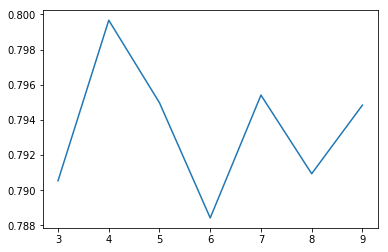

In [22]:
plt.plot(range(3,10),cvs)

In [ ]:
l.fit(all_train_df, ytrain)
preds = l.predict(all_test_df)

In [ ]:
pd.DataFrame({'Id': test[id_cols].values, 'Cover_Type':preds}).to_csv('Submissions/base_lgbm.csv',index=False)